# 07 NDarray Demo

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean, Eric Gagliano, Quinn Brencher

## Objectives

In modules 4 and 6 we used rioxarray to read and analyze rasters which were represented as xarray DataArray objects. Module 7 introduces advanced capabilities of Xarray for handling multidimensional geospatial data. In particular, we will work with N-dimensional arrays (NDarrays) that incorporate a time dimension alongside spatial coordinates, enabling time series analysis of raster data. Xarray's tutorial material is well-developed, and their [Xarray in 45 minutes](https://tutorial.xarray.dev/overview/xarray-in-45-min.html) is especially helpful in getting up to speed with some of the most important capabilities. With slight modification to include reprojection and clipping as well as excluding a couple of items, we've copied their tutorial notebook below. For more Xarray learning material, check out the [Xarray Tutorial website](https://tutorial.xarray.dev/intro.html).

### Xarray citations

S. Hoyer and J. Hamman. Xarray: N-D labeled arrays and datasets in Python. Journal of Open Research Software, 2017. URL: https://doi.org/10.5334/jors.148, doi:10.5334/jors.148.

Stephan Hoyer, Clark Fitzgerald, Joe Hamman, and others. Xarray: v2022.3.0. May 2022. URL: https://doi.org/10.5281/zenodo.59499, doi:10.5281/zenodo.59499.

<img src="https://docs.xarray.dev/en/stable/_static/Xarray_Logo_RGB_Final.svg" align="right" width="30%">

# Xarray in 45 minutes

In this lesson, we cover the basics of Xarray data structures. By the
end of the lesson, we will be able to:

- Understand the basic data structures in Xarray
- Inspect `DataArray` and `Dataset` objects.
- Read and write netCDF files using Xarray.
- Understand that there are many packages that build on top of xarray


We'll start by reviewing the various components of the Xarray data model, represented here visually:

<img src="https://docs.xarray.dev/en/stable/_images/dataset-diagram.png" align="center" width="50%">

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

xr.set_options(keep_attrs=True, display_expand_data=False)
np.set_printoptions(threshold=10, edgeitems=2)

%xmode minimal
%matplotlib inline
%config InlineBackend.figure_format='retina'

Exception reporting mode: Minimal


Xarray has a few small real-world tutorial datasets hosted in the [xarray-data](https://github.com/pydata/xarray-data) GitHub repository.

[xarray.tutorial.load_dataset](https://docs.xarray.dev/en/stable/generated/xarray.tutorial.open_dataset.html#xarray.tutorial.open_dataset) is a convenience function to download and open DataSets by name (listed at that link).

Here we'll use `air temperature` from the [National Center for Environmental Prediction](https://www.weather.gov/ncep/). Xarray objects have convenient HTML representations to give an overview of what we're working with:

In [2]:
ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB 241.2 242.5 243.5 ... 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Note that behind the scenes the `tutorial.open_dataset` downloads a file. It then uses [`xarray.open_dataset`](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html#xarray-open-dataset) function to open that file (which for this datasets is a [netCDF](https://www.unidata.ucar.edu/software/netcdf/) file). 

A few things are done automatically upon opening, but controlled by keyword arguments. For example, try passing the keyword argument `mask_and_scale=False`... what happens?

## What's in a Dataset? 

*Many DataArrays!* 

Datasets are dictionary-like containers of "DataArray"s. They are a mapping of
variable name to DataArray:

In [3]:
# pull out "air" dataarray with dictionary syntax
ds["air"]

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)> Size: 31MB
241.2 242.5 243.5 244.0 244.1 243.9 ... 297.9 297.4 297.2 296.5 296.2 295.7
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

You can save some typing by using the "attribute" or "dot" notation. This won't
work for variable names that clash with a built-in method name (like `mean` for
example).


In [4]:
# pull out dataarray using dot notation
ds.air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)> Size: 31MB
241.2 242.5 243.5 244.0 244.1 243.9 ... 297.9 297.4 297.2 296.5 296.2 295.7
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## What's in a DataArray? 

*data + (a lot of) metadata*

### Name (optional)

In [5]:
da = ds.air

da.name

'air'

### Named dimensions 

`.dims` correspond to the axes of your data. 

In this case we have 2 spatial dimensions (`latitude` and `longitude` are stored with shorthand names `lat` and `lon`) and one temporal dimension (`time`).

In [6]:
da.dims

('time', 'lat', 'lon')

### Coordinate variables 

`.coords` is a simple [data container](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#coordinates)
for coordinate variables.

Here we see the actual timestamps and spatial positions of our air temperature data:

In [7]:
da.coords

Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00

Coordinates objects support similar indexing notation


In [8]:
# extracting coordinate variables
da.lon

<xarray.DataArray 'lon' (lon: 53)> Size: 212B
200.0 202.5 205.0 207.5 210.0 212.5 ... 317.5 320.0 322.5 325.0 327.5 330.0
Coordinates:
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    axis:           X

In [9]:
# extracting coordinate variables from .coords
da.coords["lon"]

<xarray.DataArray 'lon' (lon: 53)> Size: 212B
200.0 202.5 205.0 207.5 210.0 212.5 ... 317.5 320.0 322.5 325.0 327.5 330.0
Coordinates:
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    axis:           X

It is useful to think of the values in these coordinate variables as axis
"labels" such as "tick labels" in a figure. These are coordinate locations on a
grid at which you have data.


### Arbitrary attributes 

`.attrs` is a dictionary that can contain arbitrary Python objects (strings, lists, integers, dictionaries, etc.) Your only
limitation is that some attributes may not be writeable to certain file formats.

In [10]:
da.attrs

{'long_name': '4xDaily Air temperature at sigma level 995',
 'units': 'degK',
 'precision': np.int16(2),
 'GRIB_id': np.int16(11),
 'GRIB_name': 'TMP',
 'var_desc': 'Air temperature',
 'dataset': 'NMC Reanalysis',
 'level_desc': 'Surface',
 'statistic': 'Individual Obs',
 'parent_stat': 'Other',
 'actual_range': array([185.16, 322.1 ], dtype=float32)}

In [11]:
# assign your own attributes!
da.attrs["who_is_awesome"] = "xarray"
da.attrs

{'long_name': '4xDaily Air temperature at sigma level 995',
 'units': 'degK',
 'precision': np.int16(2),
 'GRIB_id': np.int16(11),
 'GRIB_name': 'TMP',
 'var_desc': 'Air temperature',
 'dataset': 'NMC Reanalysis',
 'level_desc': 'Surface',
 'statistic': 'Individual Obs',
 'parent_stat': 'Other',
 'actual_range': array([185.16, 322.1 ], dtype=float32),
 'who_is_awesome': 'xarray'}

In [12]:
da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)> Size: 31MB
241.2 242.5 243.5 244.0 244.1 243.9 ... 297.9 297.4 297.2 296.5 296.2 295.7
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:       4xDaily Air temperature at sigma level 995
    units:           degK
    precision:       2
    GRIB_id:         11
    GRIB_name:       TMP
    var_desc:        Air temperature
    dataset:         NMC Reanalysis
    level_desc:      Surface
    statistic:       Individual Obs
    parent_stat:     Other
    actual_range:    [185.16 322.1 ]
    who_is_awesome:  xarray

### Underlying data 

`.data` contains the [numpy array](https://numpy.org) storing air temperature values.

<img src="https://raw.githubusercontent.com/numpy/numpy/623bc1fae1d47df24e7f1e29321d0c0ba2771ce0/branding/logo/primary/numpylogo.svg" width="25%">

Xarray structures wrap underlying simpler array-like data structures. This part of Xarray is quite extensible allowing for distributed array, GPU arrays, sparse arrays, arrays with units etc. We'll  briefly look at this later in this tutorial.

In [13]:
da.data

array([[[241.2 , 242.5 , ..., 235.5 , 238.6 ],
        [243.8 , 244.5 , ..., 235.3 , 239.3 ],
        ...,
        [295.9 , 296.2 , ..., 295.9 , 295.2 ],
        [296.29, 296.79, ..., 296.79, 296.6 ]],

       [[242.1 , 242.7 , ..., 233.6 , 235.8 ],
        [243.6 , 244.1 , ..., 232.5 , 235.7 ],
        ...,
        [296.2 , 296.7 , ..., 295.5 , 295.1 ],
        [296.29, 297.2 , ..., 296.4 , 296.6 ]],

       ...,

       [[245.79, 244.79, ..., 243.99, 244.79],
        [249.89, 249.29, ..., 242.49, 244.29],
        ...,
        [296.29, 297.19, ..., 295.09, 294.39],
        [297.79, 298.39, ..., 295.49, 295.19]],

       [[245.09, 244.29, ..., 241.49, 241.79],
        [249.89, 249.29, ..., 240.29, 241.69],
        ...,
        [296.09, 296.89, ..., 295.69, 295.19],
        [297.69, 298.09, ..., 296.19, 295.69]]])

In [14]:
# what is the type of the underlying data
type(da.data)

numpy.ndarray

### Review

Xarray provides two main data structures:

1. [`DataArrays`](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dataarray) that wrap underlying data containers (e.g. numpy arrays) and contain associated metadata
1. [`Datasets`](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dataset) that are dictionary-like containers of DataArrays

DataArrays contain underlying arrays and associated metadata:
1. Name
2. Dimension names
3. Coordinate variables
4. and arbitrary attributes.

---

## Why Xarray? 

Metadata provides context and provides code that is more legible. This reduces the likelihood of errors from typos and makes analysis more intuitive and fun!

### Analysis without xarray: `X(`

In [15]:
# plot the first timestep
lat = ds.air.lat.data  # numpy array
lon = ds.air.lon.data  # numpy array
temp = ds.air.data  # numpy array

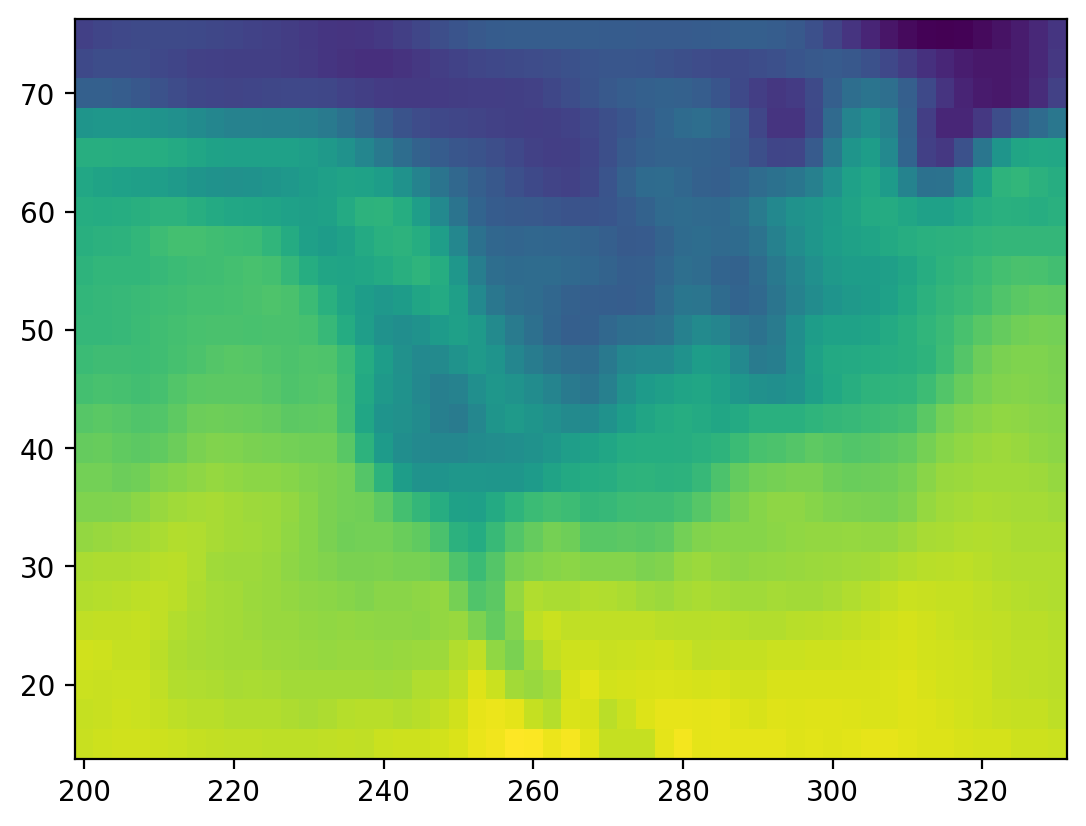

In [16]:
plt.figure()
plt.pcolormesh(lon, lat, temp[0, :, :]);

In [17]:
temp.mean(axis=1)  ## what did I just do? I can't tell by looking at this line.

array([[279.398 , 279.6664, ..., 280.3152, 280.6624],
       [279.0572, 279.538 , ..., 280.27  , 280.7976],
       ...,
       [279.398 , 279.666 , ..., 280.342 , 280.834 ],
       [279.27  , 279.354 , ..., 279.97  , 280.482 ]])

### Analysis with xarray `=)`

How readable is this code?


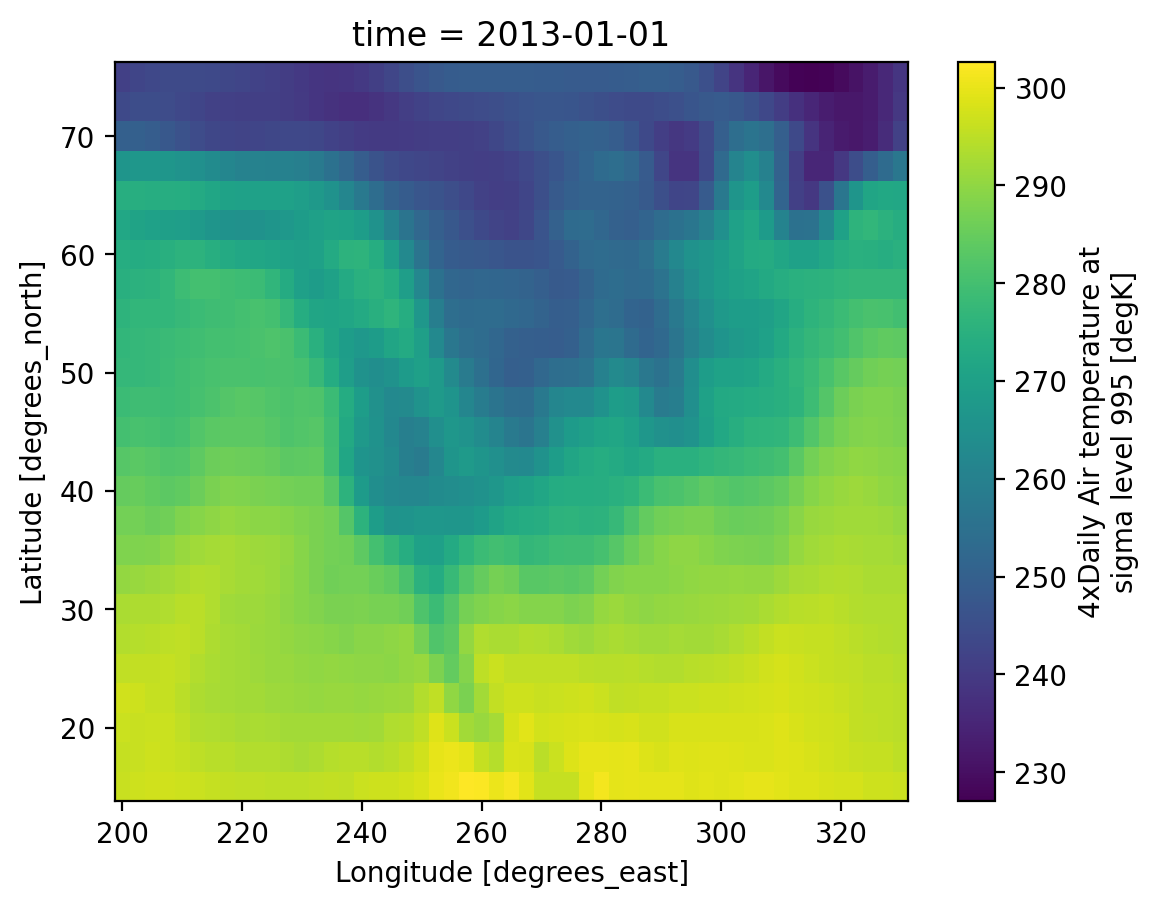

In [18]:
ds.air.isel(time=0).plot(x="lon");

Use dimension names instead of axis numbers


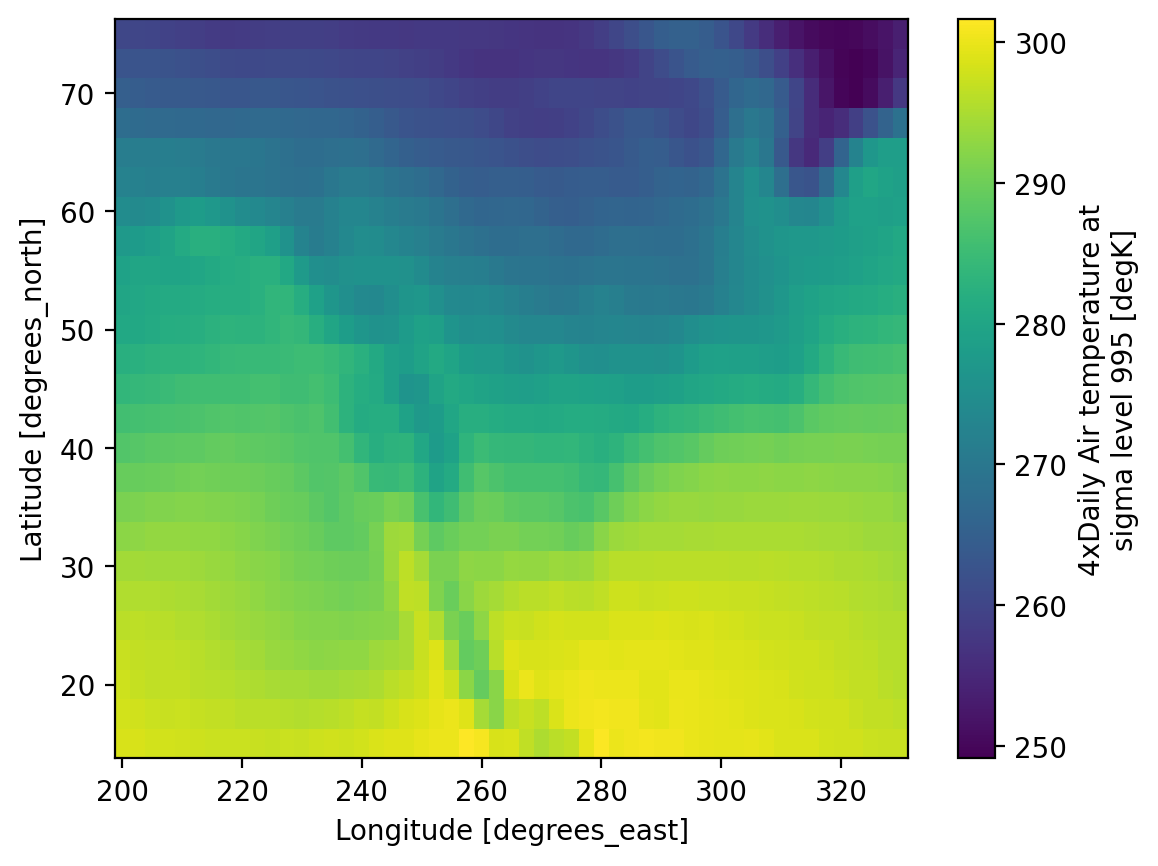

In [19]:
ds.air.mean(dim="time").plot(x="lon")

---

## Extracting data or "indexing" 

Xarray supports

- label-based indexing using `.sel`
- position-based indexing using `.isel`

See the [user guide](https://docs.xarray.dev/en/stable/indexing.html) for more.

### Label-based indexing

Xarray inherits its label-based indexing rules from pandas; this means great
support for dates and times!


In [20]:
# here's what ds looks like
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB 241.2 242.5 243.5 ... 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [21]:
# pull out data for all of 2013-May
ds.sel(time="2013-05")

<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 25, time: 124, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 992B 2013-05-01 ... 2013-05-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 1MB 259.2 259.3 259.1 ... 297.6 297.5
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [22]:
# demonstrate slicing
ds.sel(time=slice("2013-05", "2013-07"))

<xarray.Dataset> Size: 4MB
Dimensions:  (lat: 25, time: 368, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 3kB 2013-05-01 ... 2013-07-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 4MB 259.2 259.3 259.1 ... 299.5 299.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [23]:
ds.sel(time="2013")

<xarray.Dataset> Size: 15MB
Dimensions:  (lat: 25, time: 1460, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 12kB 2013-01-01 ... 2013-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 15MB 241.2 242.5 243.5 ... 295.1 294.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [24]:
# demonstrate "nearest" indexing
ds.sel(lon=240.2, method="nearest")

<xarray.Dataset> Size: 607kB
Dimensions:  (lat: 25, time: 2920)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
    lon      float32 4B 240.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat) float64 584kB 239.6 237.2 240.1 ... 294.8 296.9 298.4
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [25]:
# "nearest indexing at multiple points"
ds.sel(lon=[240.125, 234], lat=[40.3, 50.3], method="nearest")

<xarray.Dataset> Size: 117kB
Dimensions:  (lat: 2, time: 2920, lon: 2)
Coordinates:
  * lat      (lat) float32 8B 40.0 50.0
  * lon      (lon) float32 8B 240.0 235.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 93kB 268.1 283.0 265.5 ... 256.8 268.6
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

### Position-based indexing

This is similar to your usual numpy `array[0, 2, 3]` but with the power of named
dimensions!


In [26]:
ds.air.data[0, 2, 3]

np.float64(247.5)

In [27]:
# pull out time index 0, lat index 2, and lon index 3
ds.air.isel(time=0, lat=2, lon=3)  #  much better than ds.air[0, 2, 3]

<xarray.DataArray 'air' ()> Size: 8B
247.5
Coordinates:
    lat      float32 4B 70.0
    lon      float32 4B 207.5
    time     datetime64[ns] 8B 2013-01-01
Attributes:
    long_name:       4xDaily Air temperature at sigma level 995
    units:           degK
    precision:       2
    GRIB_id:         11
    GRIB_name:       TMP
    var_desc:        Air temperature
    dataset:         NMC Reanalysis
    level_desc:      Surface
    statistic:       Individual Obs
    parent_stat:     Other
    actual_range:    [185.16 322.1 ]
    who_is_awesome:  xarray

In [28]:
# demonstrate slicing
ds.air.isel(lat=slice(10))

<xarray.DataArray 'air' (time: 2920, lat: 10, lon: 53)> Size: 12MB
241.2 242.5 243.5 244.0 244.1 243.9 ... 273.4 273.8 273.5 273.8 275.0 276.2
Coordinates:
  * lat      (lat) float32 40B 75.0 72.5 70.0 67.5 65.0 62.5 60.0 57.5 55.0 52.5
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:       4xDaily Air temperature at sigma level 995
    units:           degK
    precision:       2
    GRIB_id:         11
    GRIB_name:       TMP
    var_desc:        Air temperature
    dataset:         NMC Reanalysis
    level_desc:      Surface
    statistic:       Individual Obs
    parent_stat:     Other
    actual_range:    [185.16 322.1 ]
    who_is_awesome:  xarray

---

## Concepts for computation

Consider calculating the *mean air temperature per unit surface area* for this dataset. Because latitude and longitude correspond to spherical coordinates for Earth's surface, each 2.5x2.5 degree grid cell actually has a different surface area as you move away from the equator! This is because *latitudinal length* is fixed ($ \delta Lat = R \delta \phi  $), but *longitudinal length varies with latitude* ($ \delta Lon = R \delta \lambda \cos(\phi) $)

So the [area element for lat-lon coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system#Integration_and_differentiation_in_spherical_coordinates) is


$$ \delta A = R^2 \delta\phi \, \delta\lambda \cos(\phi) $$

where $\phi$ is latitude, $\delta \phi$ is the spacing of the points in latitude, $\delta \lambda$ is the spacing of the points in longitude, and $R$ is Earth's radius. (In this formula, $\phi$ and $\lambda$ are measured in radians)

In [29]:
# Earth's average radius in meters
R = 6.371e6

# Coordinate spacing for this dataset is 2.5 x 2.5 degrees
dϕ = np.deg2rad(2.5)
dλ = np.deg2rad(2.5)

dlat = R * dϕ * xr.ones_like(ds.air.lon)
dlon = R * dλ * np.cos(np.deg2rad(ds.air.lat))
dlon.name = "dlon"
dlat.name = "dlat"

There are two concepts here:
1. you can call functions like `np.cos` and `np.deg2rad` (["numpy ufuncs"](https://numpy.org/doc/stable/reference/ufuncs.html)) on Xarray objects and receive an Xarray object back.
2. We used [ones_like](https://docs.xarray.dev/en/stable/generated/xarray.ones_like.html) to create a DataArray that looks like `ds.air.lon` in all respects, except that the data are all ones

In [30]:
# returns an xarray DataArray!
np.cos(np.deg2rad(ds.lat))

<xarray.DataArray 'lat' (lat: 25)> Size: 100B
0.2588 0.3007 0.342 0.3827 0.4226 0.4617 ... 0.9063 0.9239 0.9397 0.9537 0.9659
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    axis:           Y

In [31]:
# cell latitude length is constant with longitude
dlat

<xarray.DataArray 'dlat' (lon: 53)> Size: 424B
2.78e+05 2.78e+05 2.78e+05 2.78e+05 ... 2.78e+05 2.78e+05 2.78e+05 2.78e+05
Coordinates:
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    axis:           X

In [32]:
# cell longitude length changes with latitude
dlon

<xarray.DataArray 'dlon' (lat: 25)> Size: 200B
7.195e+04 8.359e+04 9.508e+04 1.064e+05 ... 2.612e+05 2.651e+05 2.685e+05
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    axis:           Y

### Broadcasting: expanding data

Our longitude and latitude length DataArrays are both 1D with different dimension names. If we multiple these DataArrays together the dimensionality is expanded to 2D by _broadcasting_:

In [33]:
cell_area = dlon * dlat
cell_area

<xarray.DataArray (lat: 25, lon: 53)> Size: 11kB
2e+10 2e+10 2e+10 2e+10 2e+10 ... 7.464e+10 7.464e+10 7.464e+10 7.464e+10
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    axis:           Y

The result has two dimensions because xarray realizes that dimensions `lon` and
`lat` are different so it automatically "broadcasts" to get a 2D result. See the
last row in this image from _Jake VanderPlas Python Data Science Handbook_

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/02.05-broadcasting.png" align="center">

Because xarray knows about dimension names we avoid having to create unnecessary
size-1 dimensions using `np.newaxis` or `.reshape`. For more, see the [user guide](https://docs.xarray.dev/en/stable/user-guide/computation.html#broadcasting-by-dimension-name)


---

### Alignment: putting data on the same grid

When doing arithmetic operations xarray automatically "aligns" i.e. puts the
data on the same grid. In this case `cell_area` and `ds.air` are at the same
lat, lon points we end up with a result with the same shape (25x53):


In [34]:
ds.air.isel(time=1) / cell_area

<xarray.DataArray (lat: 25, lon: 53)> Size: 11kB
1.21e-08 1.213e-08 1.215e-08 1.217e-08 ... 3.971e-09 3.971e-09 3.974e-09
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
    time     datetime64[ns] 8B 2013-01-01T06:00:00
Attributes:
    long_name:       4xDaily Air temperature at sigma level 995
    units:           degK
    precision:       2
    GRIB_id:         11
    GRIB_name:       TMP
    var_desc:        Air temperature
    dataset:         NMC Reanalysis
    level_desc:      Surface
    statistic:       Individual Obs
    parent_stat:     Other
    actual_range:    [185.16 322.1 ]
    who_is_awesome:  xarray

Now lets make `cell_area` unaligned i.e. change the coordinate labels


In [35]:
# make a copy of cell_area
# then add 1e-5 degrees to latitude
cell_area_bad = cell_area.copy(deep=True)
cell_area_bad["lat"] = cell_area.lat + 1e-5  # latitudes are off by 1e-5 degrees!
cell_area_bad

<xarray.DataArray (lat: 25, lon: 53)> Size: 11kB
2e+10 2e+10 2e+10 2e+10 2e+10 ... 7.464e+10 7.464e+10 7.464e+10 7.464e+10
Coordinates:
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    axis:           Y

In [36]:
cell_area_bad * ds.air.isel(time=1)

<xarray.DataArray (lat: 0, lon: 53)> Size: 0B

Coordinates:
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * lat      (lat) float32 0B 
    time     datetime64[ns] 8B 2013-01-01T06:00:00
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    axis:           Y

The result is an empty array with no latitude coordinates because none of them were aligned!

```{tip}
If you notice extra NaNs or missing points after xarray computation, it
means that your xarray coordinates were not aligned _exactly_.
```

To make sure variables are aligned as you think they are, do the following:

In [37]:
xr.align(cell_area_bad, ds.air, join="exact")

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'lat' ('lat',)

The above statement raises an error since the two are not aligned.

```{seealso}
For more, see
[the Xarray documentation](https://docs.xarray.dev/en/stable/user-guide/computation.html#automatic-alignment). [This tutorial notebook](https://tutorial.xarray.dev/fundamentals/02.3_aligning_data_objects.html) also covers alignment and broadcasting (*highly recommended*)
```

---

## High level computation 

(`groupby`, `resample`, `rolling`, `coarsen`, `weighted`)

Xarray has some very useful high level objects that let you do common
computations:

1. `groupby` :
   [Bin data in to groups and reduce](https://docs.xarray.dev/en/stable/groupby.html)
1. `resample` :
   [Groupby specialized for time axes. Either downsample or upsample your data.](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)
1. `rolling` :
   [Operate on rolling windows of your data e.g. running mean](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations)
1. `coarsen` :
   [Downsample your data](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays)
1. `weighted` :
   [Weight your data before reducing](https://docs.xarray.dev/en/stable/user-guide/computation.html#weighted-array-reductions)


Below we quickly demonstrate these patterns. See the user guide links above and [the tutorial](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html) for more.

### groupby


In [38]:
# here's ds
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB 241.2 242.5 243.5 ... 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [39]:
# seasonal groups
ds.groupby("time.season")

<DatasetGroupBy, grouped over 1 grouper(s), 4 groups in total:
    'season': 4/4 groups present with labels 'DJF', 'JJA', 'MAM', 'SON'>

In [40]:
# make a seasonal mean
seasonal_mean = ds.groupby("time.season").mean()
seasonal_mean

<xarray.Dataset> Size: 43kB
Dimensions:  (season: 4, lat: 25, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    air      (season, lat, lon) float64 42kB 247.0 247.0 246.7 ... 299.4 299.5
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

The seasons are out of order (they are alphabetically sorted). This is a common
annoyance. The solution is to use `.sel` to change the order of labels


In [41]:
seasonal_mean = seasonal_mean.sel(season=["DJF", "MAM", "JJA", "SON"])
seasonal_mean

<xarray.Dataset> Size: 43kB
Dimensions:  (season: 4, lat: 25, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * season   (season) object 32B 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    air      (season, lat, lon) float64 42kB 247.0 247.0 246.7 ... 299.4 299.5
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

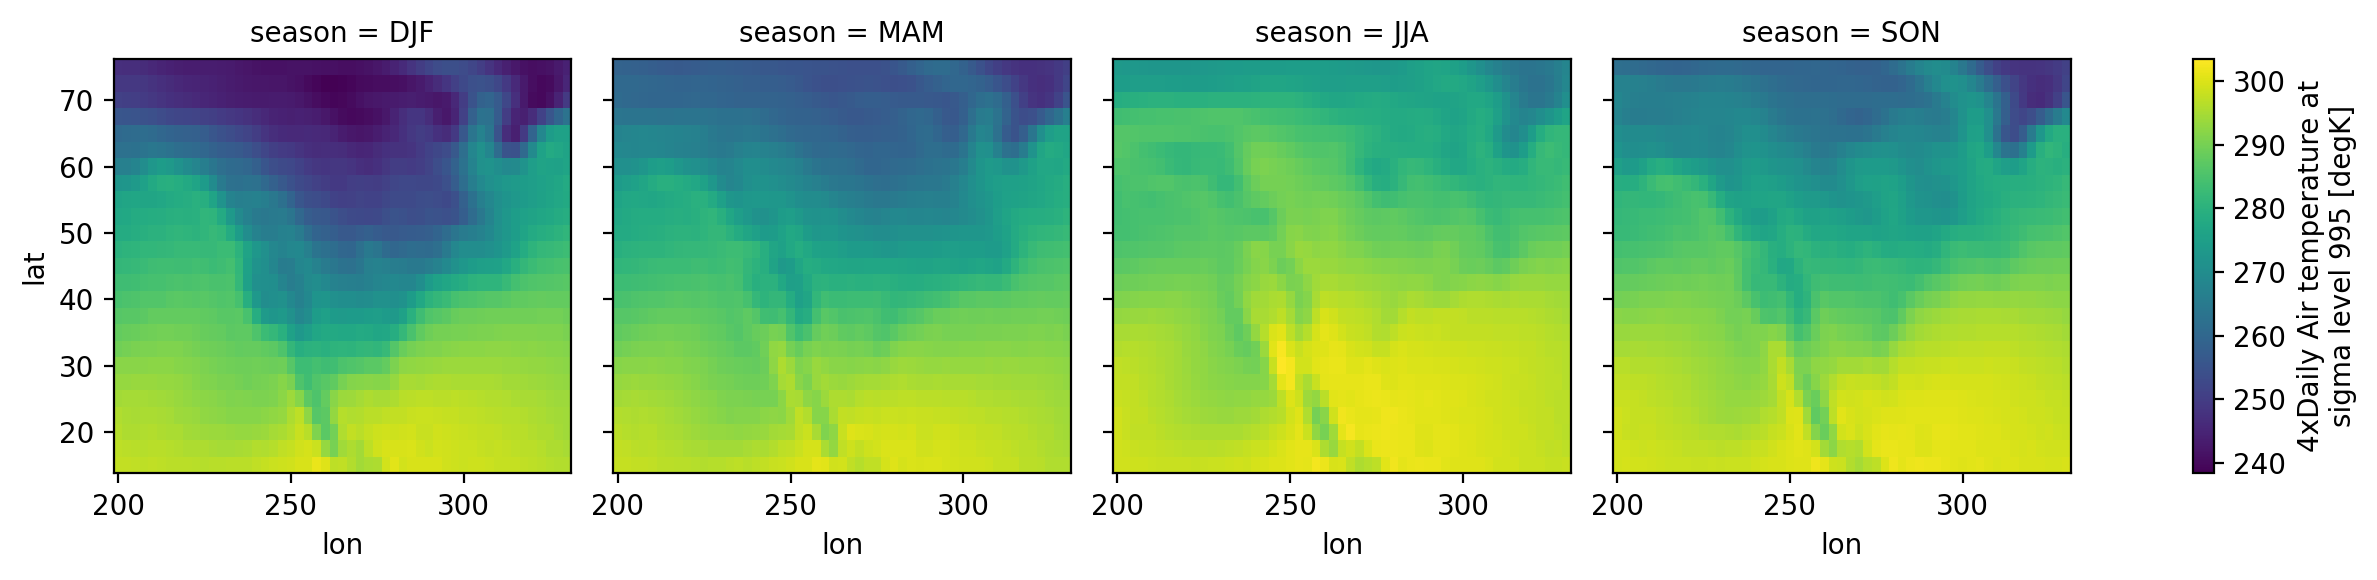

In [42]:
seasonal_mean.air.plot(col="season")

### resample


In [43]:
# resample to monthly frequency
ds.resample(time="M").mean()

/home/eric/miniconda3/envs/uwgda2025/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


<xarray.Dataset> Size: 255kB
Dimensions:  (time: 24, lat: 25, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 192B 2013-01-31 2013-02-28 ... 2014-12-31
Data variables:
    air      (time, lat, lon) float64 254kB 244.5 244.7 244.7 ... 297.7 297.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

### weighted


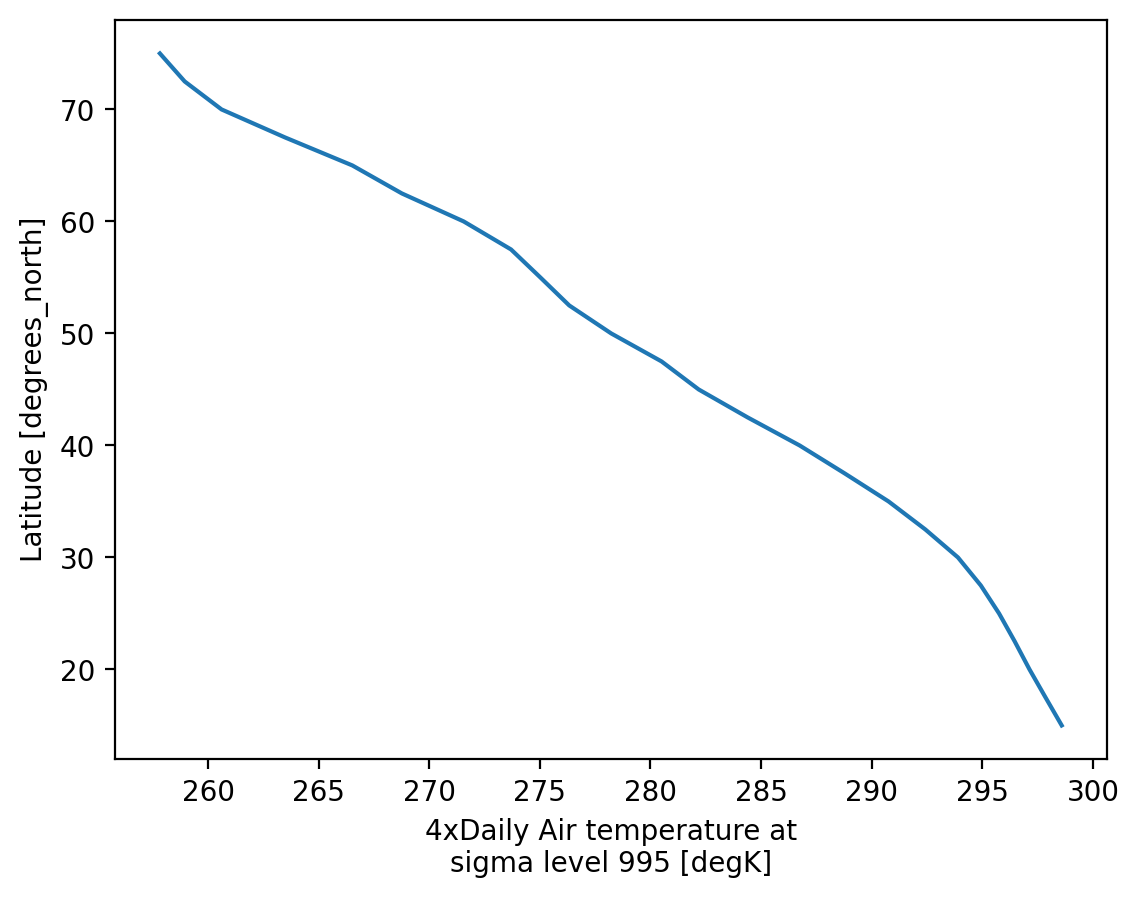

In [44]:
# weight by cell_area and take mean over (time, lon)
ds.weighted(cell_area).mean(["lon", "time"]).air.plot(y="lat");

---

## Visualization

(`.plot`)


We have seen very simple plots earlier. Xarray also lets you easily visualize
3D and 4D datasets by presenting multiple facets (or panels or subplots) showing
variations across rows and/or columns.

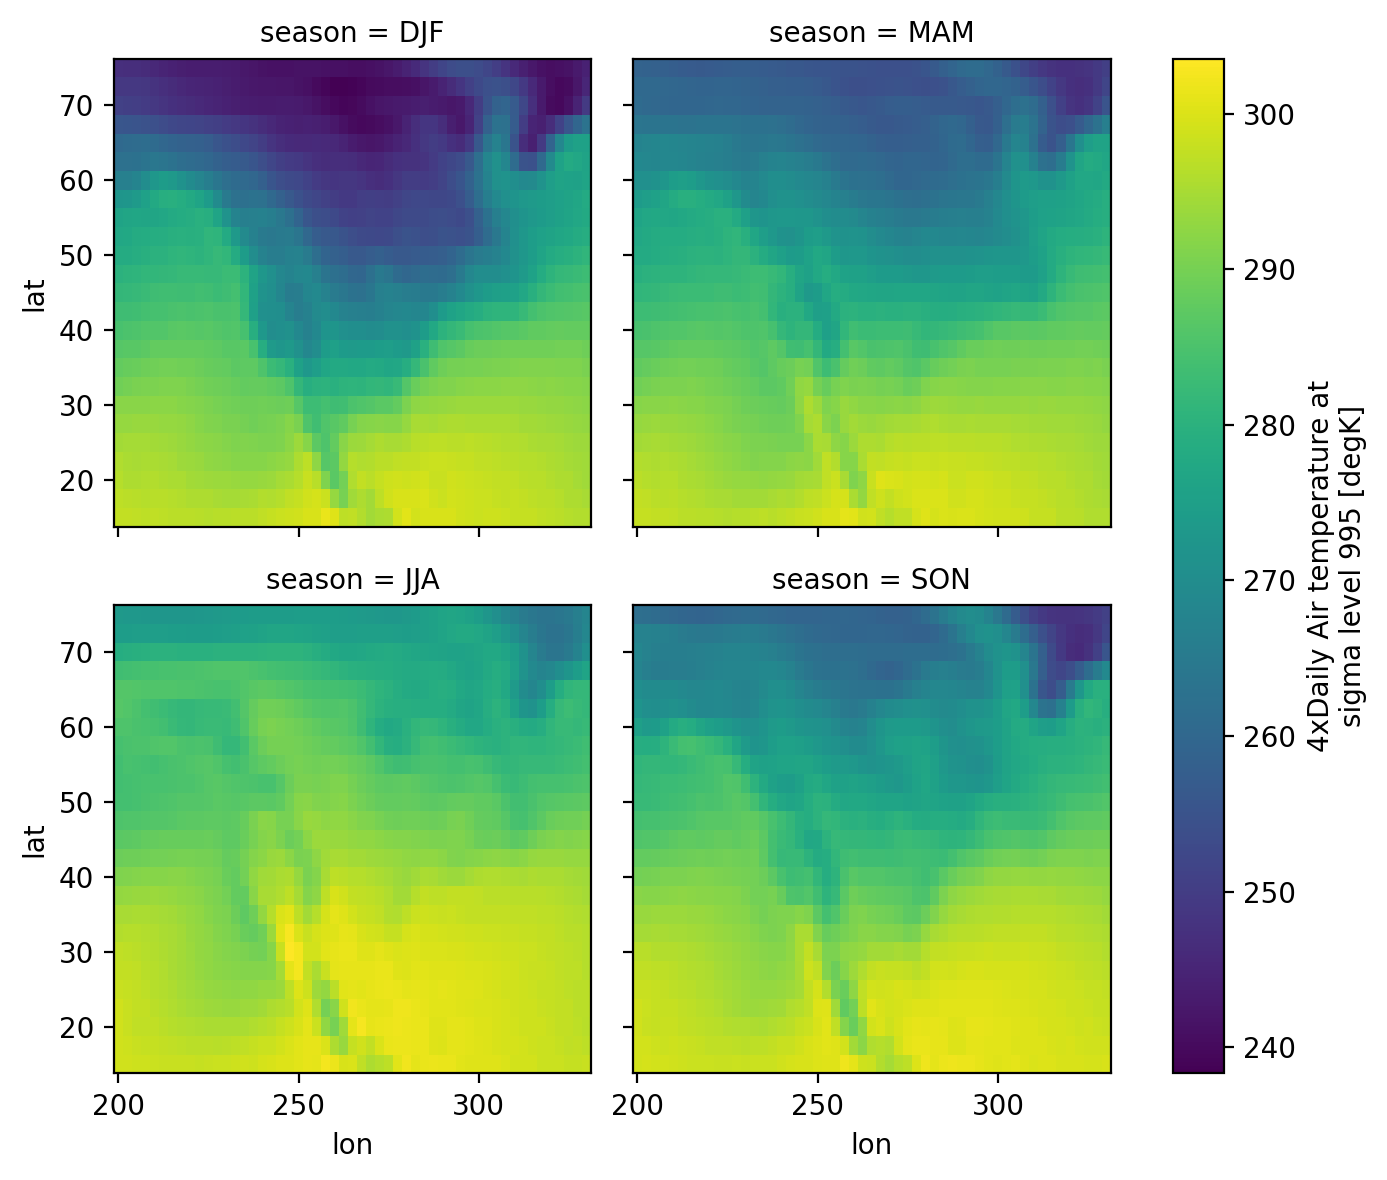

In [45]:
# facet the seasonal_mean
seasonal_mean.air.plot(col="season", col_wrap=2);

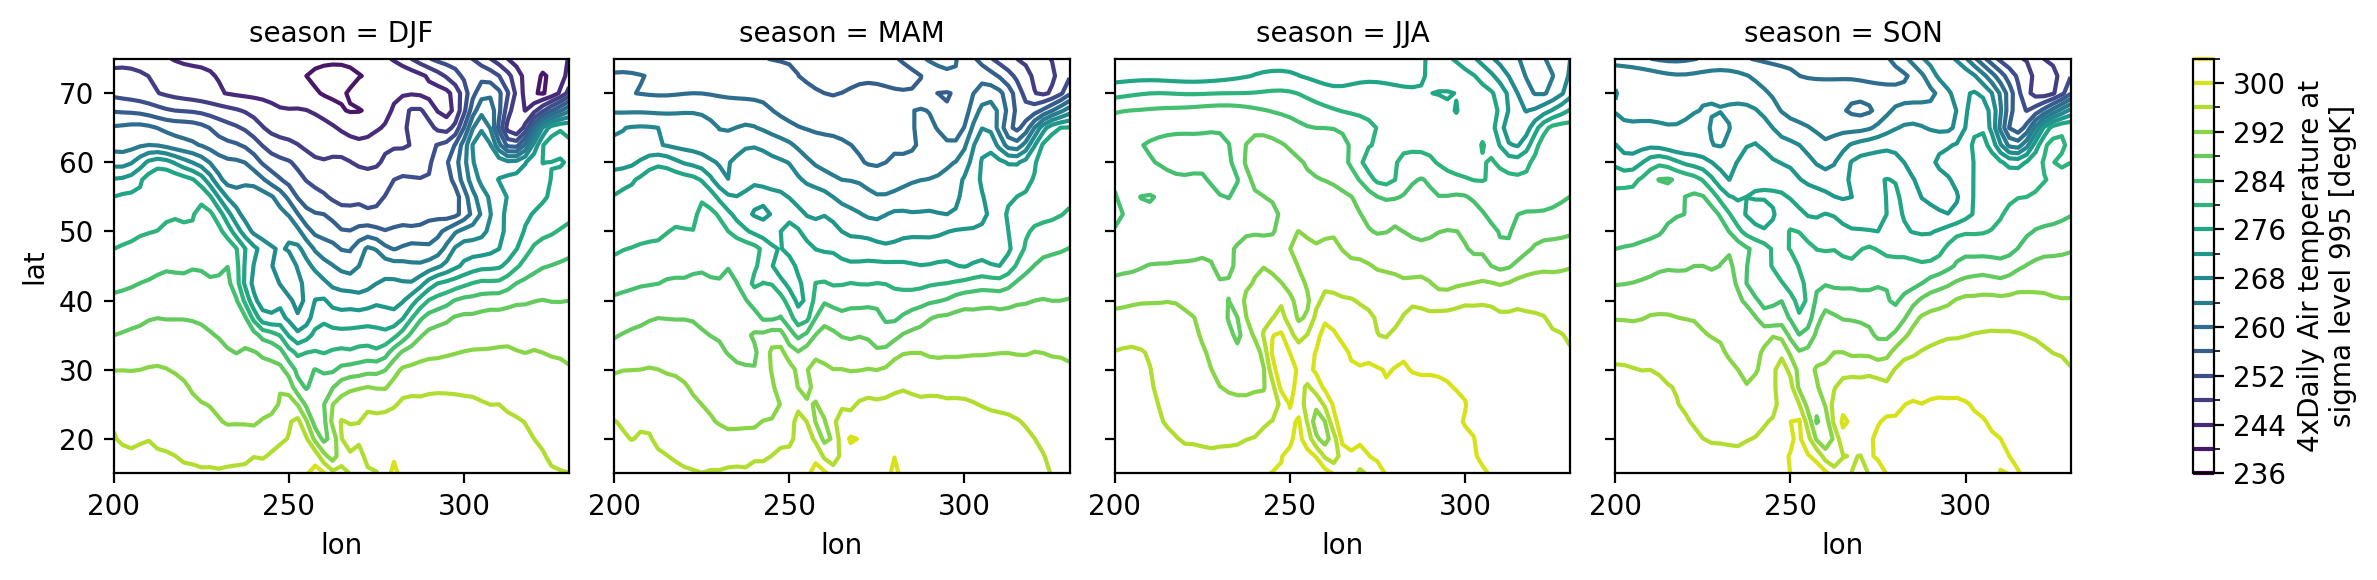

In [46]:
# contours
seasonal_mean.air.plot.contour(col="season", levels=20, add_colorbar=True);

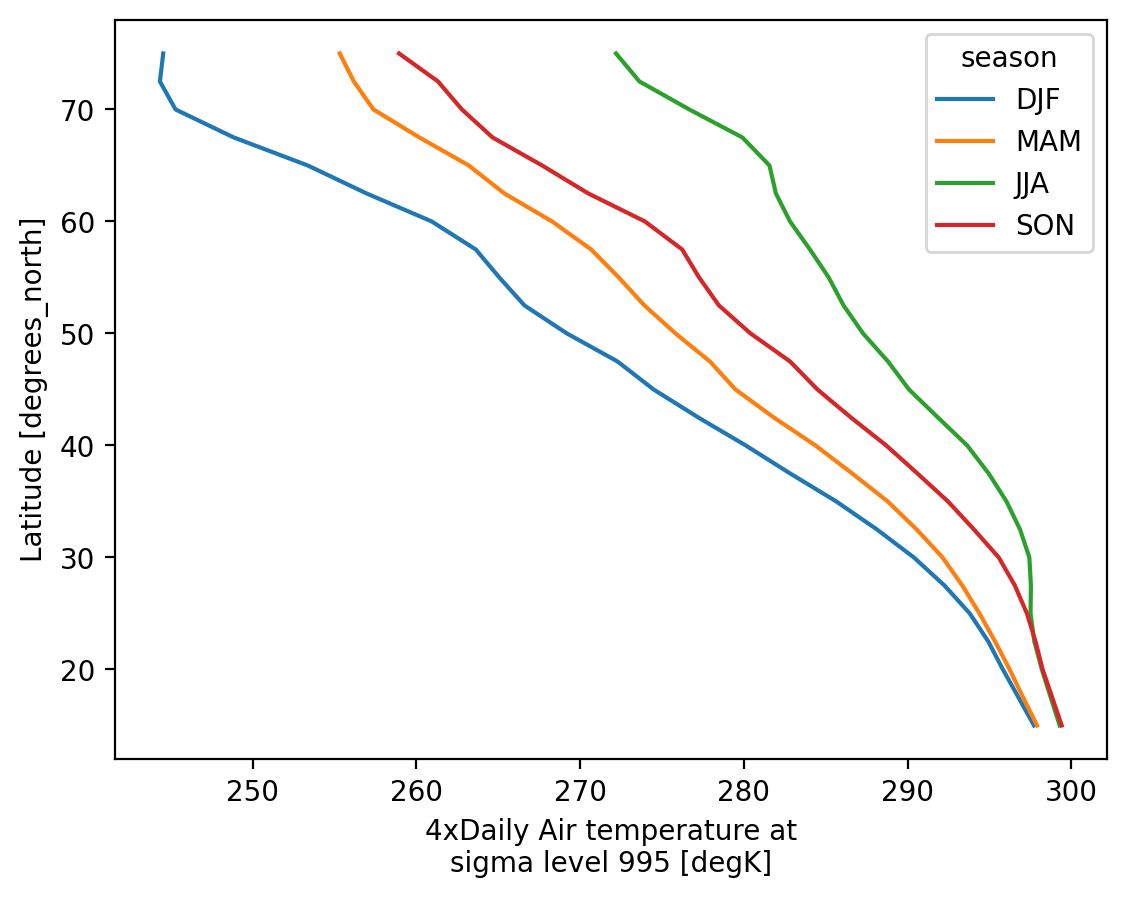

In [47]:
# line plots too? wut
seasonal_mean.air.mean("lon").plot.line(hue="season", y="lat");

For more see the [user guide](https://docs.xarray.dev/en/stable/plotting.html), the [gallery](https://docs.xarray.dev/en/stable/examples/visualization_gallery.html), and [the tutorial material](https://tutorial.xarray.dev/fundamentals/04.0_plotting.html).

---

## Band math / convert variables

We're in degrees Kelvin, let's practice converting!

In [48]:
ds["air"]

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)> Size: 31MB
241.2 242.5 243.5 244.0 244.1 243.9 ... 297.9 297.4 297.2 296.5 296.2 295.7
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:       4xDaily Air temperature at sigma level 995
    units:           degK
    precision:       2
    GRIB_id:         11
    GRIB_name:       TMP
    var_desc:        Air temperature
    dataset:         NMC Reanalysis
    level_desc:      Surface
    statistic:       Individual Obs
    parent_stat:     Other
    actual_range:    [185.16 322.1 ]
    who_is_awesome:  xarray

In [49]:
ds["air"].attrs

{'long_name': '4xDaily Air temperature at sigma level 995',
 'units': 'degK',
 'precision': np.int16(2),
 'GRIB_id': np.int16(11),
 'GRIB_name': 'TMP',
 'var_desc': 'Air temperature',
 'dataset': 'NMC Reanalysis',
 'level_desc': 'Surface',
 'statistic': 'Individual Obs',
 'parent_stat': 'Other',
 'actual_range': array([185.16, 322.1 ], dtype=float32),
 'who_is_awesome': 'xarray'}

Notice these nice attributes on the air variable! If we convert away from Kelvin, we should probbaly update the units attribute for good bookeeping!

In [50]:
ds["air"] = ds["air"] - 273.15
ds["air"].attrs["units"] = "Celsius"
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB -31.95 -30.65 -29.65 ... 23.04 22.54
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

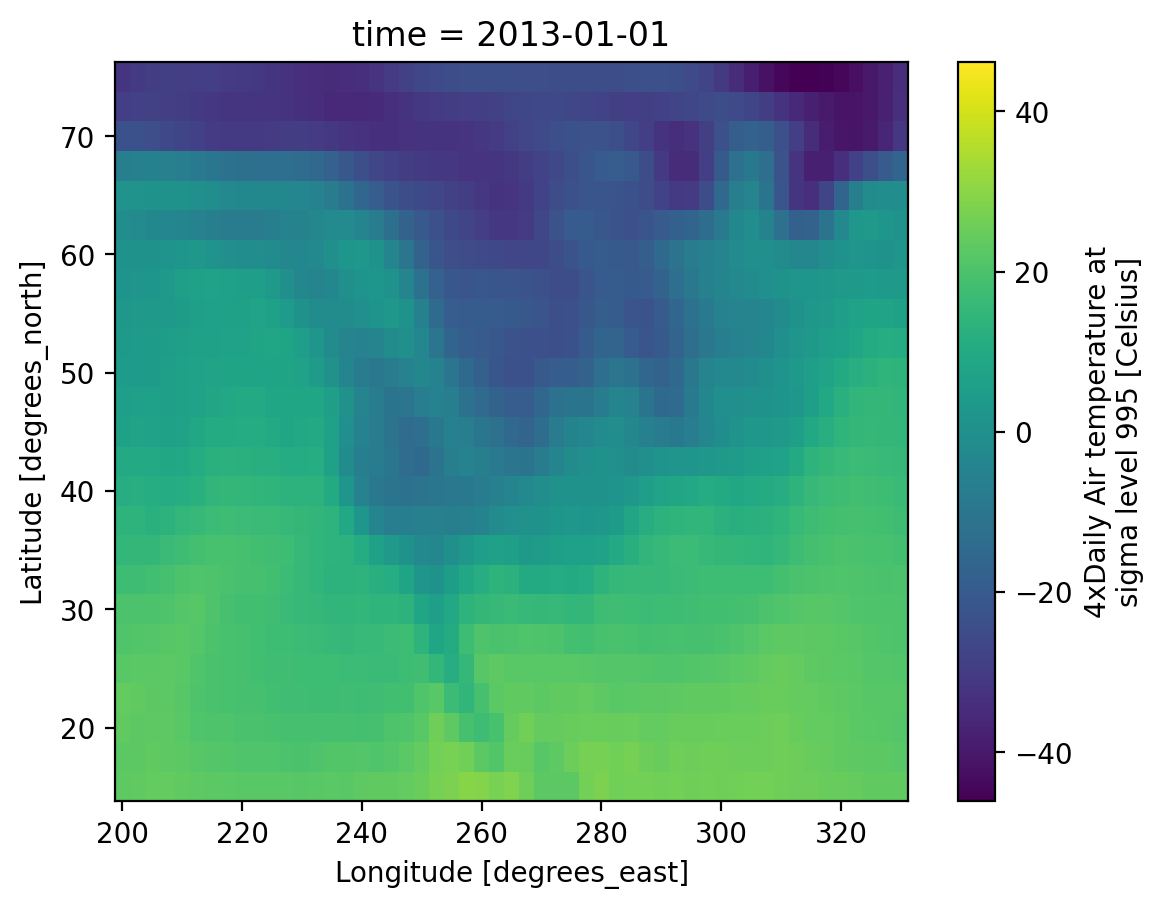

In [51]:
ds["air"].isel(time=0).plot(cmap="viridis")

That's great, the plot also has updated units! Now what if we had a friend that couldn't interpret Celsius easily?? To Fahrenheit...

In [52]:
ds["air"] = ds["air"] * (9/5) + 32
ds["air"].attrs["units"] = "Fahrenheit"
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB -25.51 -23.17 -21.37 ... 73.47 72.57
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

So let's show the mean temperature in Fahrenheit for 2013...

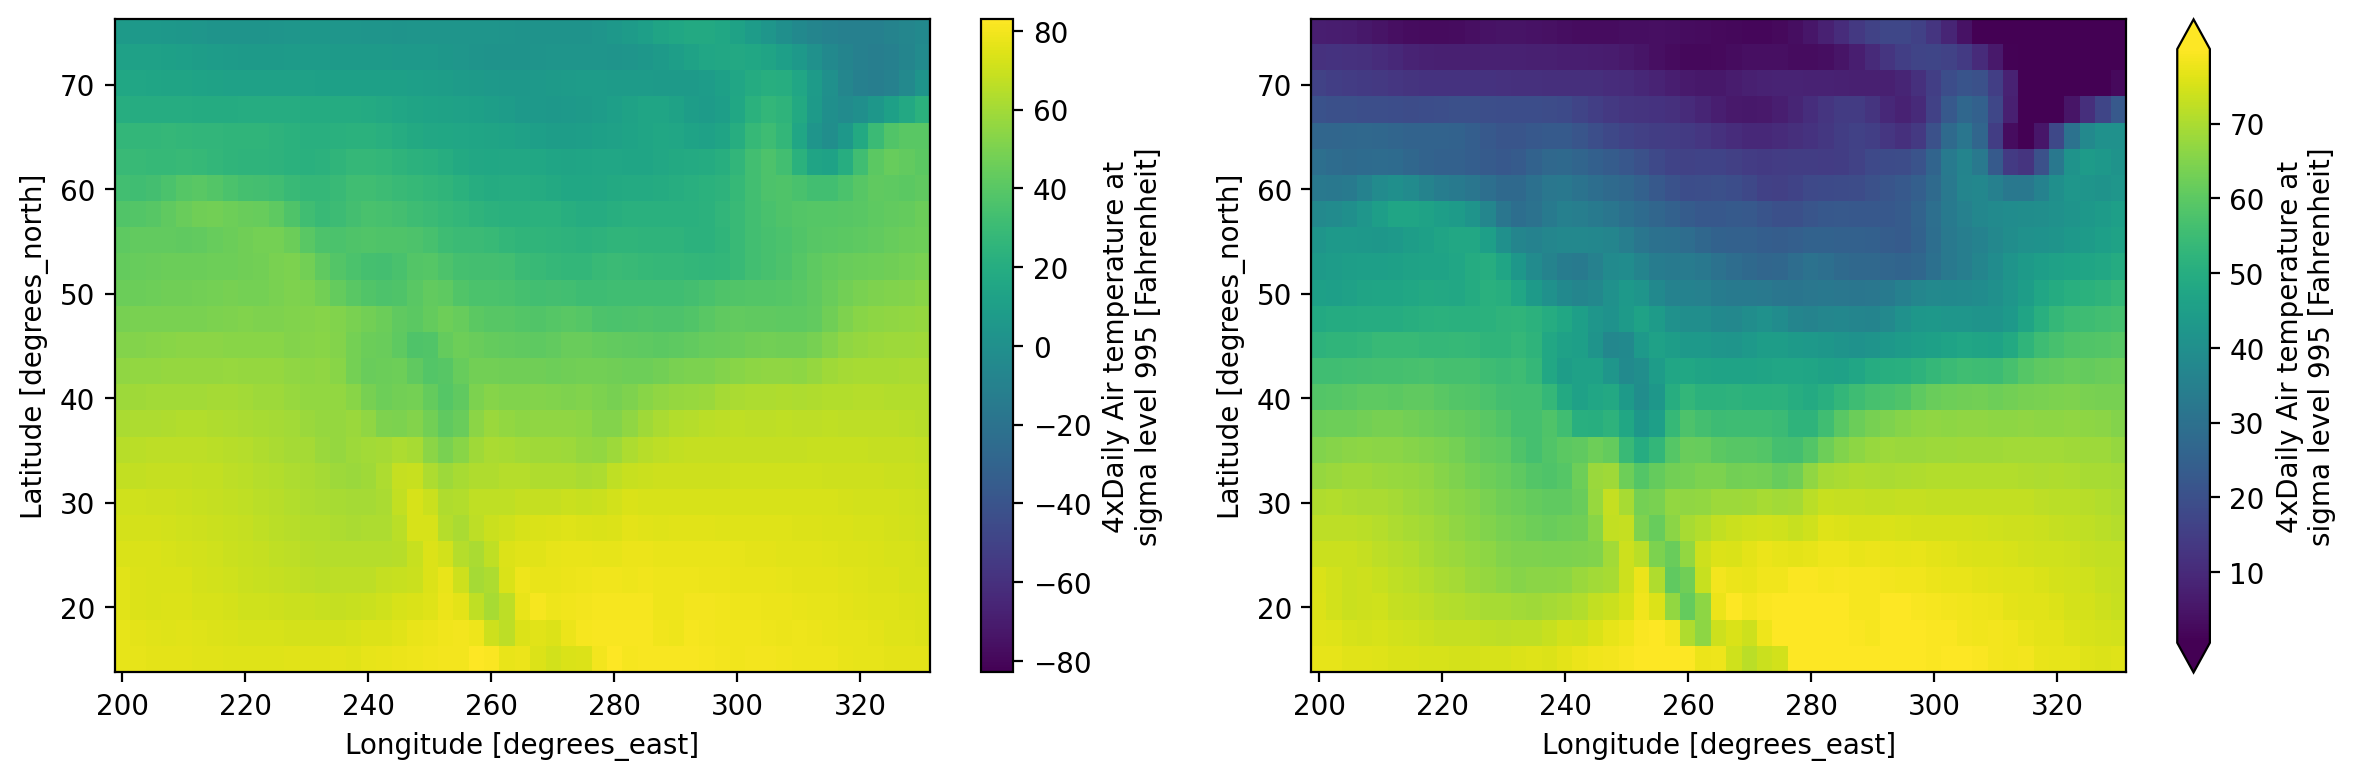

In [53]:
f,axs=plt.subplots(1,2,figsize=(12,4))

ds["air"].sel(time="2013").mean(dim="time").plot.imshow(ax=axs[0], cmap="viridis")
ds["air"].sel(time="2013").mean(dim="time").plot.imshow(ax=axs[1], cmap="viridis",robust=True)

f.tight_layout()

What does `robust=True` in the `.plot.imshow()` call do again?

---

## Reprojection and clipping

Since rioxarray extends Xarray DataArray and Dataset objects, we can use our favorite rioxarray functions using the `.rio` accessor like we've done before!

In [54]:
ds = ds.rio.write_crs("EPSG:4326")
ds

<xarray.Dataset> Size: 31MB
Dimensions:      (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat          (lat) float32 100B 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
  * lon          (lon) float32 212B 200.0 202.5 205.0 ... 325.0 327.5 330.0
  * time         (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
    spatial_ref  int64 8B 0
Data variables:
    air          (time, lat, lon) float64 31MB -25.51 -23.17 ... 73.47 72.57
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [55]:
ds.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [56]:
projected_ds = ds.rio.reproject("EPSG:2163")
projected_ds

<xarray.Dataset> Size: 89MB
Dimensions:      (x: 81, y: 47, time: 2920)
Coordinates:
  * x            (x) float64 648B -6.192e+06 -6.028e+06 ... 6.735e+06 6.898e+06
  * y            (y) float64 376B 4.247e+06 4.084e+06 ... -3.116e+06 -3.28e+06
  * time         (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
    spatial_ref  int64 8B 0
Data variables:
    air          (time, y, x) float64 89MB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

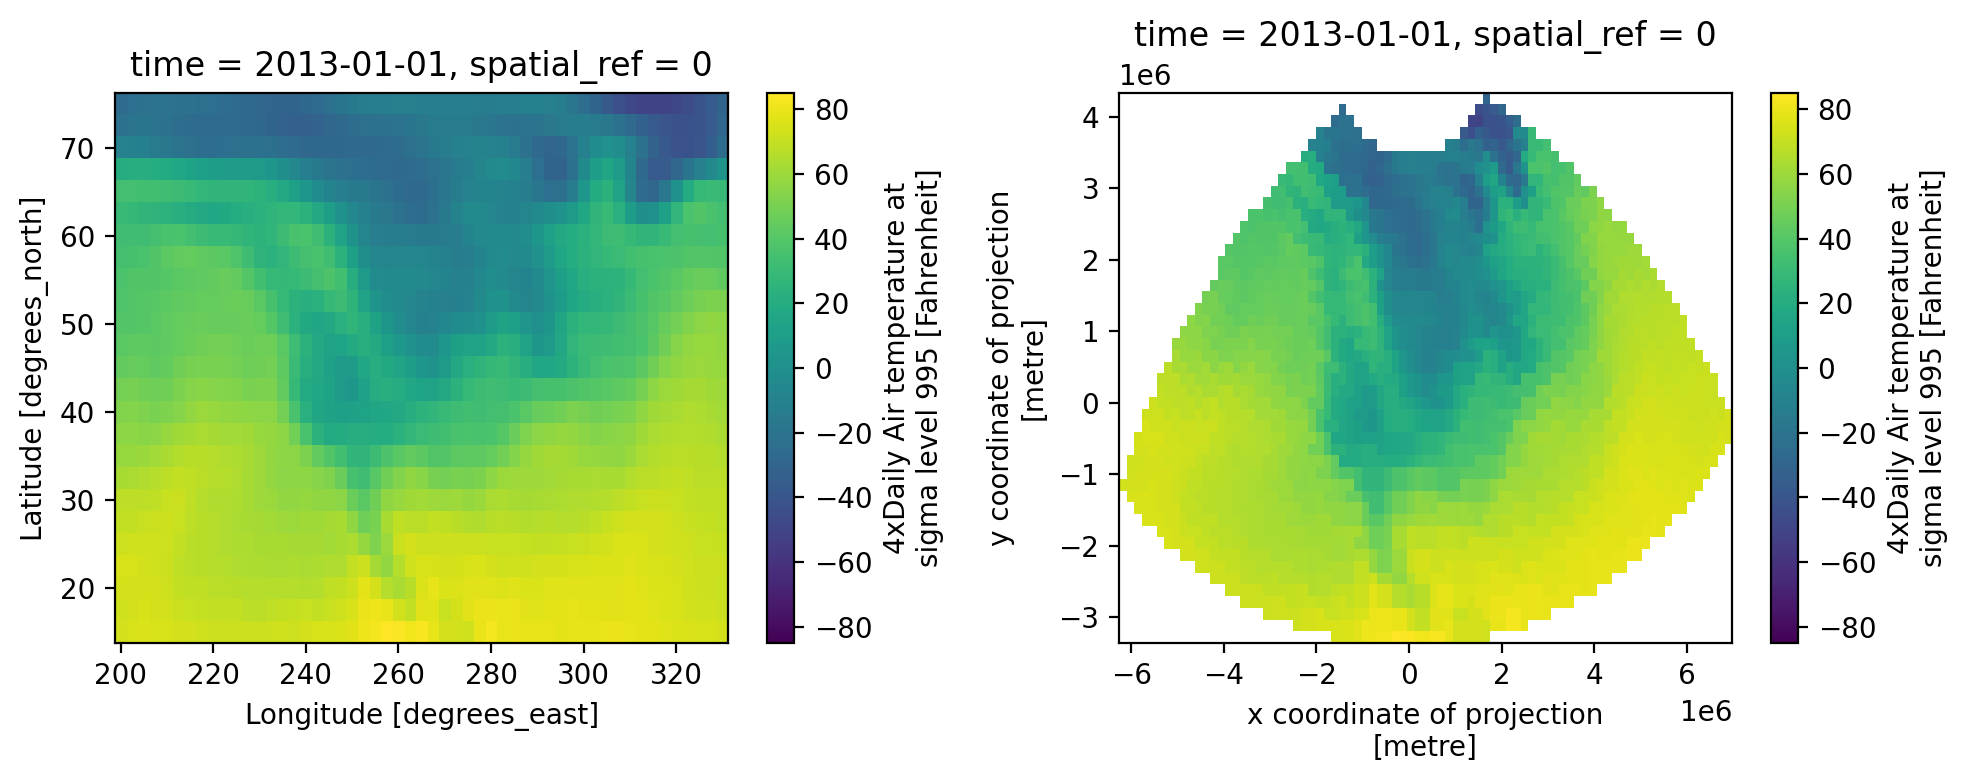

In [57]:
f,axs=plt.subplots(1,2,figsize=(10,4))

ds["air"].isel(time=0).plot.imshow(ax=axs[0],cmap="viridis")
projected_ds["air"].isel(time=0).plot.imshow(ax=axs[1],cmap="viridis")

f.tight_layout()

In [58]:
import geopandas as gpd
states_gdf = gpd.read_file('http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json')

In [59]:
states_projected_gdf = states_gdf.to_crs(projected_ds.rio.crs)

In [60]:
wa_projected_gdf = states_projected_gdf[states_projected_gdf["NAME"] == "Washington"]
tx_projected_gdf = states_projected_gdf[states_projected_gdf["NAME"] == "Texas"]

In [61]:
wa_projected_and_clipped_ds = projected_ds.rio.clip(wa_projected_gdf.geometry)
tx_projected_and_clipped_ds = projected_ds.rio.clip(tx_projected_gdf.geometry, all_touched=True) # note to self, demonstrate what all_touched does here :)

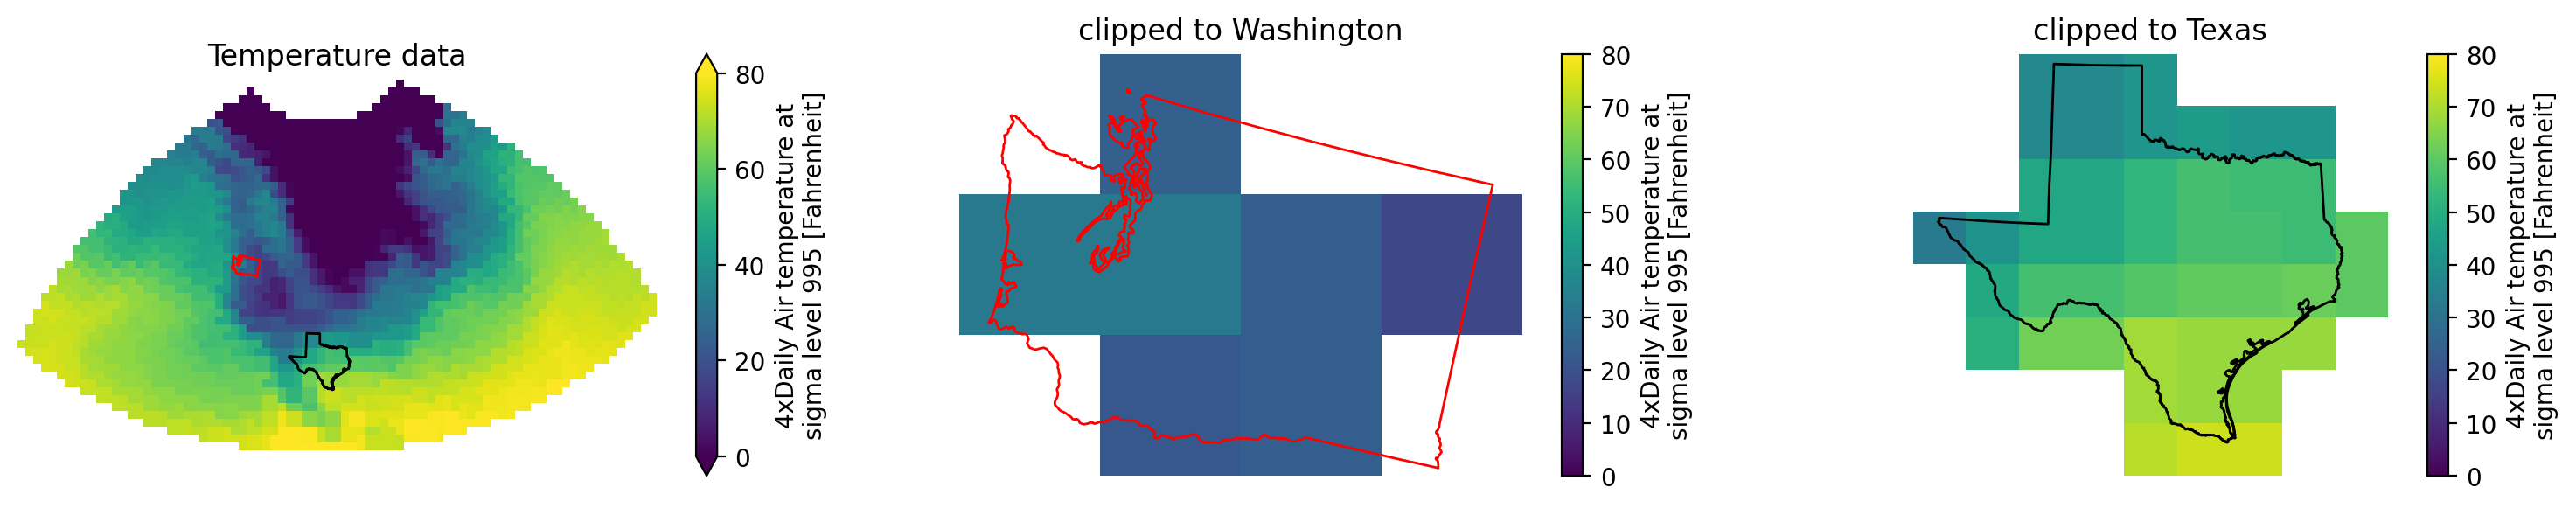

In [62]:
f, axs = plt.subplots(1, 3, figsize=(15, 3))

projected_ds["air"].isel(time=0).plot.imshow(ax=axs[0],cmap="viridis",vmin=0,vmax=80)

wa_projected_and_clipped_ds["air"].isel(time=0).plot.imshow(ax=axs[1],vmin=0,vmax=80)

tx_projected_and_clipped_ds["air"].isel(time=0).plot.imshow(ax=axs[2],vmin=0,vmax=80)

wa_projected_gdf.plot(ax=axs[0], edgecolor="red", facecolor="none")
tx_projected_gdf.plot(ax=axs[0], edgecolor="black", facecolor="none")

wa_projected_gdf.plot(ax=axs[1], edgecolor="red", facecolor="none")
tx_projected_gdf.plot(ax=axs[2], edgecolor="black", facecolor="none")

axs[0].set_title("Temperature data")
axs[1].set_title("clipped to Washington")
axs[2].set_title("clipped to Texas")

for ax in axs:
    ax.set_aspect("equal")
    ax.axis("off")

f.tight_layout()

By the way, what does `all_touched=True` do in the `.rio.clip()` call?

---

## Reading and writing files

Xarray supports many disk formats. Below is a small example using netCDF. For
more see the [documentation](https://docs.xarray.dev/en/stable/user-guide/io.html)


In [63]:
# write to netCDF
ds.to_netcdf("my-example-dataset.nc")

```{note}
To avoid the `SerializationWarning` you can assign a _FillValue for any NaNs in 'air' array by adding the keyword argument `encoding=dict(air=dict(_FillValue=-9999))`
```

In [64]:
# read from disk
fromdisk = xr.open_dataset("my-example-dataset.nc")
fromdisk

<xarray.Dataset> Size: 31MB
Dimensions:      (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat          (lat) float32 100B 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
  * lon          (lon) float32 212B 200.0 202.5 205.0 ... 325.0 327.5 330.0
  * time         (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air          (time, lat, lon) float64 31MB ...
    spatial_ref  int64 8B ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [65]:
# check that the two are identical
ds.identical(fromdisk)

False

```{tip}
A common use case to read datasets that are a collection of many netCDF
files. See the [documentation](https://docs.xarray.dev/en/stable/user-guide/io.html#reading-multi-file-datasets) for how
to handle that.
```

Finally to read other file formats, you might find yourself reading in the data using a different library and then creating a DataArray([docs](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#creating-a-dataarray), [tutorial](https://tutorial.xarray.dev/fundamentals/01.1_creating_data_structures.html)) from scratch. For example, you might use `h5py` to open an HDF5 file and then create a Dataset from that.
For MATLAB files you might use `scipy.io.loadmat` or `h5py` depending on the version of MATLAB file you're opening and then construct a Dataset.

---

## The scientific python ecosystem

Xarray ties in to the larger scientific python ecosystem and in turn many
packages build on top of xarray. A long list of such packages is here:
<https://docs.xarray.dev/en/stable/related-projects.html>.

Now we will demonstrate some cool features.


### Pandas: tabular data structures

You can easily [convert](https://docs.xarray.dev/en/stable/pandas.html) between xarray and [pandas](https://pandas.pydata.org/) structures. This allows you to conveniently use the extensive pandas 
ecosystem of packages (like [seaborn](https://seaborn.pydata.org/)) for your work.


In [66]:
# convert to pandas dataframe
df = ds.isel(time=slice(10)).to_dataframe()
df

air  spatial_ref
lat  time                lon                       
75.0 2013-01-01 00:00:00 200.0 -25.510            0
                         202.5 -23.170            0
                         205.0 -21.370            0
                         207.5 -20.470            0
                         210.0 -20.290            0
...                                ...          ...
15.0 2013-01-03 06:00:00 320.0  74.930            0
                         322.5  75.452            0
                         325.0  74.750            0
                         327.5  74.552            0
                         330.0  75.110            0

[13250 rows x 2 columns]

In [67]:
# convert dataframe to xarray
df.to_xarray()

<xarray.Dataset> Size: 212kB
Dimensions:      (lat: 25, time: 10, lon: 53)
Coordinates:
  * lat          (lat) float32 100B 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
  * time         (time) datetime64[ns] 80B 2013-01-01 ... 2013-01-03T06:00:00
  * lon          (lon) float32 212B 200.0 202.5 205.0 ... 325.0 327.5 330.0
Data variables:
    air          (lat, time, lon) float64 106kB -25.51 -23.17 ... 74.55 75.11
    spatial_ref  (lat, time, lon) int64 106kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0

### Alternative array types

This notebook has focused on Numpy arrays. Xarray can wrap [other array](https://docs.xarray.dev/en/stable/user-guide/duckarrays.html) types! For example:

<img src="https://docs.dask.org/en/stable/_images/dask_horizontal.svg" width="20%"> [distributed parallel arrays](https://docs.dask.org/en/latest/array.html) & [Xarray user guide on Dask](https://docs.xarray.dev/en/stable/user-guide/dask.html)

<img src="https://raw.githubusercontent.com/pydata/sparse/master/docs/logo.svg" width="15%"> **pydata/sparse** : [sparse arrays](https://sparse.pydata.org)

<img src="https://raw.githubusercontent.com/cupy/cupy.dev/master/images/cupy_logo.png" width="22%"> [GPU arrays](https://cupy.dev) & [cupy-xarray](https://cupy-xarray.readthedocs.io/)

<img src="https://pint.readthedocs.io/en/stable/_static/logo-full.jpg" width="10%"> **pint** : [unit-aware arrays](https://pint.readthedocs.io) & [pint-xarray](https://github.com/xarray-contrib/pint-xarray)


### Dask

Dask cuts up NumPy arrays into blocks and parallelizes your analysis code across
these blocks

<img src="https://raw.githubusercontent.com/dask/dask/main/docs/source/images/dask-array.svg" style="width:45%">


In [68]:
# demonstrate dask dataset
dasky = xr.tutorial.open_dataset(
    "air_temperature",
    chunks={"time": 10},  # 10 time steps in each block
)

dasky.air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)> Size: 31MB
dask.array<chunksize=(10, 25, 53), meta=np.ndarray>
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

All computations with dask-backed xarray objects are lazy, allowing you to build
up a complicated chain of analysis steps quickly


In [69]:
# demonstrate lazy mean
dasky.air.mean("lat")

<xarray.DataArray 'air' (time: 2920, lon: 53)> Size: 1MB
dask.array<chunksize=(10, 53), meta=np.ndarray>
Coordinates:
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

To get concrete values, call `.compute` or `.load`


In [70]:
# "compute" the mean
dasky.air.mean("lat").compute()

<xarray.DataArray 'air' (time: 2920, lon: 53)> Size: 1MB
279.4 279.7 279.7 279.7 280.0 279.9 ... 277.4 278.3 278.9 279.4 280.0 280.5
Coordinates:
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [71]:
# import hvplot.xarray
# ds.air.hvplot(groupby="time", clim=(270, 300), widget_location='bottom')

### Other cool packages

- [hvplot](https://hvplot.holoviz.org/user_guide/Gridded_Data.html) : quickly generate interactive plots from your data
- [xgcm](https://xgcm.readthedocs.io/) : grid-aware operations with xarray
  objects
- [xrft](https://xrft.readthedocs.io/) : fourier transforms with xarray
- [xclim](https://xclim.readthedocs.io/) : calculating climate indices with
  xarray objects
- [intake-xarray](https://intake-xarray.readthedocs.io/) : forget about file
  paths
- [rioxarray](https://corteva.github.io/rioxarray/stable/index.html) : raster
  files and xarray
- [xesmf](https://xesmf.readthedocs.io/) : regrid using ESMF
- [MetPy](https://unidata.github.io/MetPy/latest/index.html) : tools for working
  with weather data

Check the Xarray [Ecosystem](https://docs.xarray.dev/en/stable/ecosystem.html) page and [this tutorial](https://tutorial.xarray.dev/intermediate/xarray_ecosystem.html) for even more packages and demonstrations.

## Next

1. Read the [tutorial](https://tutorial.xarray.dev) material and [user guide](https://docs.xarray.dev/en/stable/user-guide/index.html)
1. See the description of [common terms](https://docs.xarray.dev/en/stable/terminology.html) used in the xarray documentation: 
1. Answers to common questions on "how to do X" with Xarray are [here](https://docs.xarray.dev/en/stable/howdoi.html)
1. Ryan Abernathey has a book on data analysis with a [chapter on Xarray](https://earth-env-data-science.github.io/lectures/xarray/xarray_intro.html)
1. [Project Pythia](https://projectpythia.org/) has [foundational](https://foundations.projectpythia.org/landing-page.html) and more [advanced](https://cookbooks.projectpythia.org/) material on Xarray. Pythia also aggregates other [Python learning resources](https://projectpythia.org/resource-gallery.html).
1. The [Xarray Github Discussions](https://github.com/pydata/xarray/discussions) and [Pangeo Discourse](https://discourse.pangeo.io/) are good places to ask questions.
1. Tell your friends! Tweet!


## Welcome!

Xarray is an open-source project and gladly welcomes all kinds of contributions. This could include reporting bugs, discussing new enhancements, contributing code, helping answer user questions, contributing documentation (even small edits like fixing spelling mistakes or rewording to make the text clearer). Welcome!